# Imports and Options

Original parameters for combinedCD version 2:

```
min.cells,3
min.count.rna,500
max.count.rna,60000
min.count.atac,1000
max.count.atac,70000
min.features,200
max.features,2000
max.percent.mt,30
min.percent.mt,0
pct.reads.peaks,20
nucleosome,2
tss.score,1
dims,20
res,0.5
future.mem,62000
future.workers,6
```

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import scanpy as scale
import matplotlib
import matplotlib.pyplot as plt
import corescpy as cr
from corescpy.class_sc import Omics
import warnings
import pandas as pd
import numpy as np

matplotlib.rcParams['figure.figsize'] = (10, 10)
warnings.showwarning = lambda mess, cat, path, lineno, file=None, line=None: \
    print(f"{path}:{lineno}: {cat.__name__}: {mess}", file=file)
warnings.filterwarnings("always", category=UserWarning, module="corescpy")

ddd = "/home/elizabeth/elizabeth/projects/data/"
file = os.path.join(ddd,
                    "combined-cd/2023-05-12_CombinedCD-v2_new.h5ad")
file_gca = os.path.join(
    ddd, "public/gut-cell-atlas/Full_obj_log_counts_soupx_v2.h5ad")
genes = list(pd.read_csv(os.path.join(ddd, "panel_senmayo.csv")).gene)
genes_main = ["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST"]

raw = False

col_sample_id = "object"
col_subject = "PubID"
method_cluster = "leiden"
col_cell_type = "ClusterAnnotation"
col_condition = "Inflammation"
key_control, key_treatment = "Non-inflamed", "Inflamed"
# col_cell_type = "majority_voting"
kws_init = {
    "assay": None, "col_gene_symbols": ["features", "_index"][int(raw)],
    "col_cell_type": col_cell_type, "col_sample_id": col_sample_id,
    "col_subject": col_subject, "col_condition": col_condition,
    "key_control": key_control, "key_treatment": key_treatment}
kws_pp = {"kws_hvg": {"flavor": "cell_ranger", "batch_key": col_sample_id},
          "target_sum": 10000.0,
          "cell_filter_pmt": [0, 30],
          "cell_filter_ngene": [200, 2000],
          "cell_filter_ncounts": [500, 60000],
          "gene_filter_ncell": [3, None],
          "regress_out": None,
          "kws_scale": True}
kws_cluster = {"method_cluster": method_cluster,
               "kws_umap": {},
               "kws_neighbors": None,
               "kws_pca": {"n_comps": 20, "use_highly_variable": True},
               "kws_cluster": {},
               "resolution": 0.5}
if method_cluster == "louvain":
    kws_cluster["kws_cluster"].update({"flavor": "vtraag"})

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

# Object Initialization

In [2]:
self = Omics(file, **kws_init, raw=raw)
self.adata.raw = None  # causes problems for some reason

# Certain Aesthetic Changes
self.adata = self.adata[self.adata.obs.Region == "Ileum"]
self.adata.obs.replace({"Sex": {"M": "Male"}}, inplace=True)

# Fix Special Characters
self.adata.obs.loc[:, col_condition] = self.adata.obs[col_condition].apply(
    lambda x: re.sub("_", "-", x))  # causes issues with pydeseq2 package
key_treatment, key_control = [re.sub("_", "-", x)
                              for x in [key_treatment, key_control ]]
self._keys.update({"key_treatment": key_treatment,
                   "key_control": key_control})



<<< INITIALIZING OMICS CLASS OBJECT >>>




col_gene_symbols="features"
col_cell_type="ClusterAnnotation"
col_sample_id="object"
col_batch="object"
col_subject="PubID"
col_condition="Inflammation"
col_num_umis=None



key_control="Non-inflamed"
key_treatment="Inflamed"


<<< LOADING FILE /home/elizabeth/elizabeth/projects/data/combined-cd/2023-05-12_CombinedCD-v2_new.h5ad with sc.read() >>>
dsfasfda AnnData object with n_obs × n_vars = 215723 × 36511
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'object', 'group', 'percent.rb', 'percent.hb', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'ClusterAnnotation', 'Bin', 'PubID', 'PubID_Obj', 'Library', 'AgeAtEnrollment', 'Sex', 'Ancestry', 'TNFAtProcedure', 'DiagnosisYear', 'FistulaCurrent', 'Region', 'Inflammation', 'Race', 'MultiomePair', 'ident'
    uns: 'X_name'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts'


Cell Counts: Initial


Observations: 21572

# Processing


Un-Used Keyword Arguments: {'assay_protein': None, 'col_condition': 'Inflammation', 'col_num_umis': None}




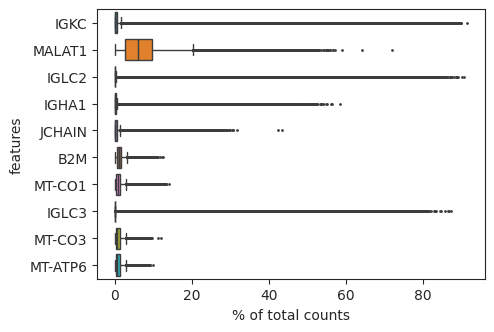

dsfasfda AnnData object with n_obs × n_vars = 215723 × 36511
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'object', 'group', 'percent.rb', 'percent.hb', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'ClusterAnnotation', 'Bin', 'PubID', 'PubID_Obj', 'Library', 'AgeAtEnrollment', 'Sex', 'Ancestry', 'TNFAtProcedure', 'DiagnosisYear', 'FistulaCurrent', 'Region', 'Inflammation', 'Race', 'MultiomePair', 'ident', 'n_counts', 'log_counts', 'n_genes'
    uns: 'X_name'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts', 'counts'


Cell Counts: Initial


Observations: 215723

----------------------------------------
LAYER DIMENSIONS:
----------------------------------------
logcounts: (215723, 36511)
counts: (215723, 36511)
----------------------------------------


 ClusterAnnotation
CD4+ T                    48522
IgA1 Plasma               45161
B Cells                   29088
CD8+ T, NK                20054
Fibro

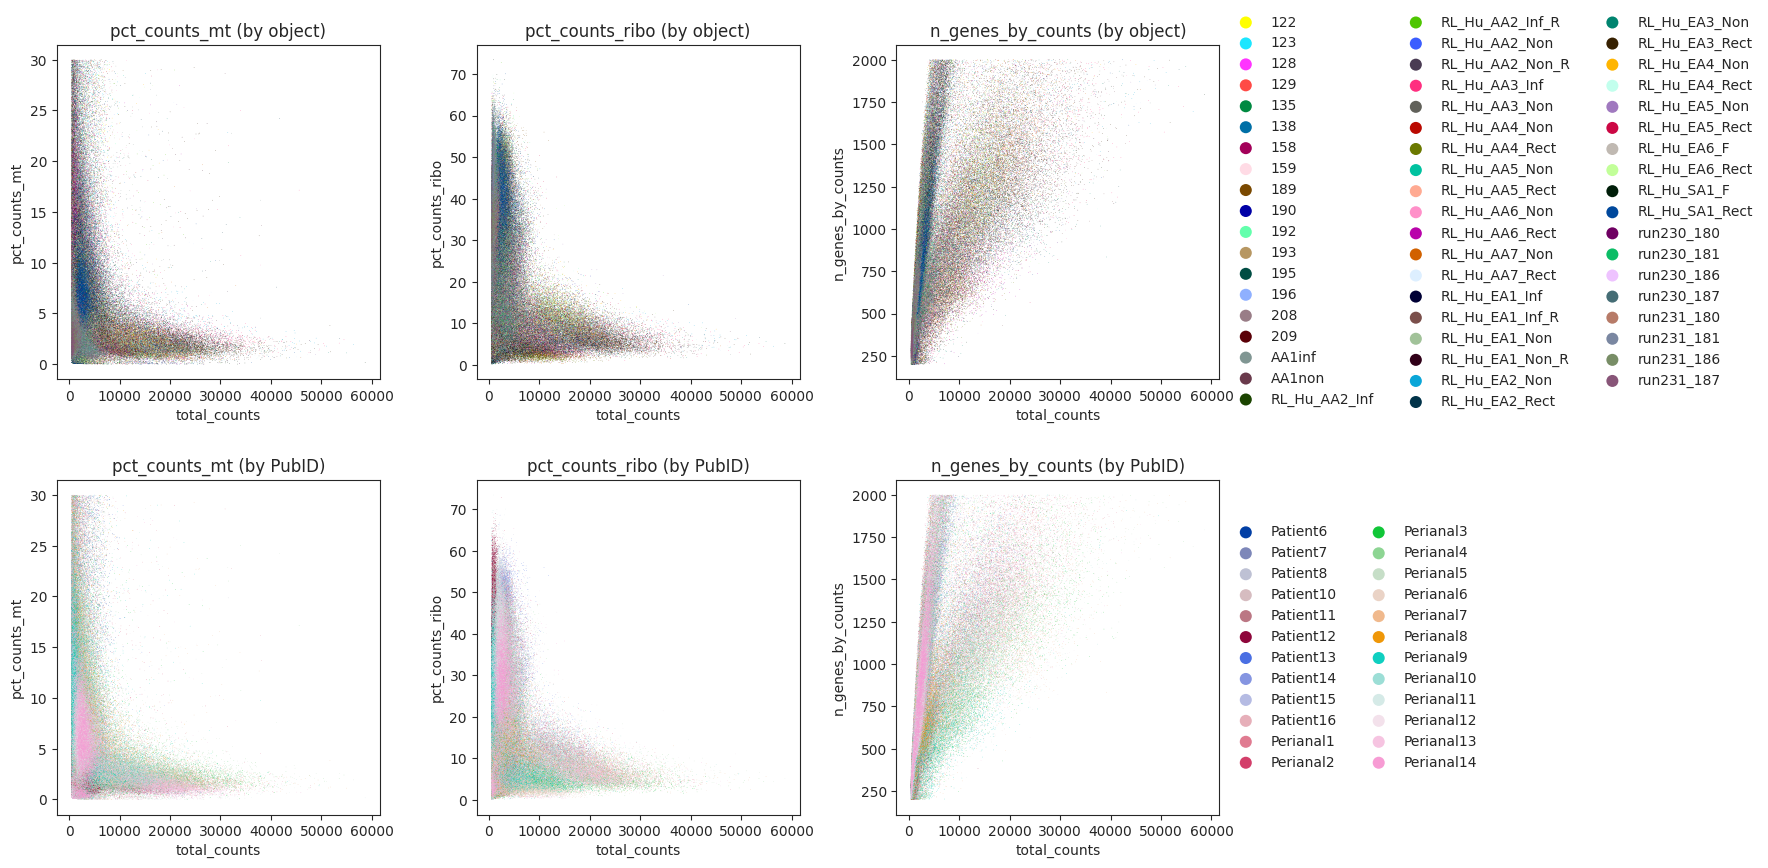

In [3]:
%%time

_ = self.preprocess(**kws_pp)

# Clustering

## UMAP

In [ ]:
%%time

self.cluster(**kws_cluster)
# self.plot_umap(legend_loc="on data")

## Markers

In [ ]:
%%time

marks = self.find_markers(n_genes=3, plot_kws={"kind": "box"})

## Annotation

In [ ]:
%%time

self.annotate_clusters("Cells_Intestinal_Tract.pkl")
marks = self.find_markers(col_cell_type="majority_voting", n_genes=3)

# Plots

## Options

Choose available genes of interest, etc.

In [ ]:
goi = list(set(genes_main).intersection(self.rna.var_names))

## General GEX

In [ ]:
_ = self.plot(goi, kws_umap=dict(cmap="magma", vcenter=None, vmax=10),
              kws_heat=dict(vcenter=0, cmap="coolwarm"),
              kws_matrix=dict(vcenter=0, cmap="coolwarm"))

## GEX by Inflammation (and TNF)

### Single Gene

In [ ]:
# fig = self.plot_compare(genes=goi, kind="violin", palette=["r", "gray"])
_ = self.plot_compare(genes=goi, kind="box", palette=["r", "gray"])
_ = self.plot_compare(genes=goi, kind="box", palette=["r", "gray"],
                      columns="TNFAtProcedure", long_labels=True)

### Multi-Gene, Multi-Color

In [ ]:
# default_fs = plt.rcParams["figure.figsize"]
# plt.rcParams["figure.figsize"] = (60, 60)
ggg = list(set(genes).intersection(set(self.rna.var_names)))
for g in [list(x) for x in np.array_split(ggg, 24)]:
    _ = self.plot_umap(g, group=self._columns["col_condition"],
                       figsize=(20, 20), frameon=False)

In [ ]:
# import re
# self.adata.write_h5ade.sub("_new.h5ad", "_processed.h5ad", file))

# Analysis  

To save the preprocessed object:

```
import re
self.adata.write_h5ade.sub("_new.h5ad", "_processed.h5ad", file))
```

## Ligand-Receptor with DEA

Ligand-receptor analysis with overlaid differential expression analysis on pseudo-bulk data

In [ ]:
%%time

key_targets = None
key_sources = ["Epithelial", "Endothelial, Lymphatic",
               "Fibroblasts", "Myofibroblasts", "Myeloid", "ILC3"]
# kws_deseq2 = dict(min_mu=0.5, min_disp=1e-08, max_disp=10, min_replicates=3)
kws_deseq2 = dict(figsize=(45, 30))
out_lr = self.calculate_receptor_ligand(
    col_condition=True, figsize=(25, 15), p_threshold=0.01,
    min_prop=0, min_count=0, min_total_count=0, kws_deseq2=kws_deseq2,
    key_targets=key_targets, key_sources=key_sources, n_jobs=4)

In [ ]:
# You can make new plots (e.., different targets/source, figure size, etc.)
# without re-running all the analyses. You can also save figures this way.
# key_sources = ["Epithelial", "Endothelial, Lymphatic", "Myeloid"]
# self.plot_receptor_ligand(key_sources=key_sources, key_targets=key_sources,
#                           out_dir="plots_ilealCD", figsize=(30, 15),
#                           figsize_dea=(45, 30), dpi=100)

# Save Figures
# for c in self.figures["receptor_ligand"]:
#     if isinstance(self.figures["receptor_ligand"][c], dict):
#         for q in self.figures["receptor_ligand"][c]:
#             self.figures["receptor_ligand"][c][q].save(
#                 f"plots_ilealCD/{c}_{q}.png", limitsize=False)
#     else:
#         self.figures["receptor_ligand"][c].save(
#             f"plots_ilealCD/{c}.png", limitsize=False)

## Causal Network

In [ ]:
%%time

key_source, key_target = "Epithelial", "Myeloid"
out = self.calculate_causal_network(key_source, key_target)

## Functional Analysis (Pseudo-Bulk)

In [ ]:
# out_fx = self.run_fx_analysis([self._columns["col_condition"]])

## Gene Set Enrichment Analysis

### By Cell Type & Inflammation

This way will choose the pathways shown in the plot using the scores and p-values.

In [ ]:
%%time

out_gsea = self.run_gsea(key_condition="Epithelial_Inflamed")

### Plot Specified Pathways

This list could have been supplied to the `ifn_pathways` argument in the `self.run_gsea()` call above to get these plots with the original run.

This function allows you to plot different pathways and/or use different arguments for plotting (e.g., for aesthetics) without re-running the analysis.

In [ ]:
ifn_pathways = [
    "REACTOME_DNA_DOUBLE_STRAND_BREAK_REPAIR",
    "REACTOME_NUCLEOTIDE_EXCISION_REPAIR",
    "REACTOME_CELLULAR_RESPONSE_TO_STARVATION",
    "REACTOME_TIGHT_JUNCTION_INTERACTIONS",
    "REACTOME_CELL_CELL_JUNCTION_ORGANIZATION",
    "REACTOME_PLASMA_LIPOPROTEIN_REMODELING",
    str("REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_"
        "A_NON_LYMPHOID_CELL"),
    "REACTOME_SIGNALING_BY_PDGFR_IN_DISEASE",
    "REACTOME_SWITCHING_OF_ORIGINS_TO_A_POST_REPLICATIVE_STATE"]
self.plot_gsea(ifn_pathways=ifn_pathways, cmap="magma")

### Across Cell Types

In [ ]:
out_gsea_i = self.run_gsea(col_condition=self._columns["col_condition"],
                           key_condition=self._keys["key_treatment"],
                           ifn_pathways=True)  # auto-choose pathways to plot

## Composition Analysis

In [ ]:
out_comp = self.run_composition_analysis(covariates=["TNFAtProcedure"])

# Workspace

In [ ]:
# lig_rec = "COPA-CD74"
# lig_rec = "MYL9-CD69"
# lig_rec = "HMGB1-CXCR4"
# lig_rec = "CXCL14-CXCR4"
# lig_rec = "MFGE8-PDGFRB"
# lig_rec = "CALM1-MYLK"
# lig_rec = "CALM2-MYLK"
# lig_rec = "CALM3-MYLK"
lig_rec = "HMGB1-CXCR4"
p_threshold = 0.001

out_lr = self.results["receptor_ligand"]
ligand, receptor = lig_rec.split("-")
for s in out_lr[list(out_lr.keys())[0]].source.unique():
    print(f"Source = {s}\n\n")
    for c in out_lr:
        dff = out_lr[c][out_lr[c].cellphone_pvals < p_threshold]
        targs = list(dff[(dff["source"] == s) & (
            dff["ligand"] == ligand) & (
                dff["receptor_complex"] == receptor)]["target"])
        print(f"{c}\n{'-' * len(c)}\n{targs}")
    print("\n\n", "=" * 80, "\n\n\n")

In [ ]:
res = self.results["receptor_ligand"]["liana_res"]
targs = res[(res.cellphone_pvals < p_threshold) & (res.lr_means > 1)
            ].groupby(["receptor", "ligand", "source", res.index.names[0]]
                      ).apply(lambda x: list(x.target))
print(targs.head())
ktc = self._keys["key_treatment"], self._keys["key_control"]
for i in [[0, 1], [1, 0]]:  # loop (1)  tx v. control, (2) vice-versa
    print("=" * 80, ["Tx v. C", "C vs. Tx"][i], "=" * 80, "\n\n")
    print(targs.loc[receptor, ligand, :].reset_index(0).groupby(
        "source").apply(lambda x: list(set(x.loc[ktc[i[0]], 0]).difference(
            set(x.loc[ktc[i[1]], 0])))))  # difference in significant sources

In [ ]:
targs.reset_index()[targs.reset_index().receptor == "MYLK"
                    ].reset_index().ligand.unique()

In [ ]:
rrr = res[(res.ligand == ligand) & (res.receptor == receptor) & (
    res.cellphone_pvals < 1e-3) & (res.lr_means > 1)]
rrr

In [ ]:
tmp = [out_lr[c][out_lr[c].cellphone_pvals < 0.01].target for c in ktc]
targs = []
for s in out_lr[list(out_lr.keys())[0]].source.unique():
    print(s)
    for t in tmp:
        targs += [list(dff[(dff["source"] == s) & (dff["ligand"] == ligand) & (
            dff["receptor_complex"] == receptor)]["target"])]
    print(s + ": " + ", ".join(set(targs[0]).difference(targs[1])))